In [1]:
!pip install transformers peft accelerate datasets -q
!pip install trl -q
!pip install --upgrade transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 121.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 83.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 43.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
from huggingface_hub import login
token = "" #add your token here
login(token=token)

In [10]:
pip install matplotlib

# Evaluation - Exact Match - Zero Shot Promt

Evaluating on 50 samples.

=== Loading Fine-Tuned LLaMA 3 Model: /content/drive/MyDrive/Codes_and_models/Llama3/llama3-sql-lora/final-merged ===


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]


=== Evaluating Fine-Tuned Model on 50 samples (Exact Match Only) ===

--- Fine-Tuned Model Exact Match Summary ---
Exact Matches: 30/50 (60.00%)
Fine-tuned model resources released.

=== Loading Base LLaMA 3 Model: meta-llama/Meta-Llama-3-8B-Instruct ===


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]


=== Evaluating Base Model on 50 samples (Exact Match Only) ===

--- Base Model Exact Match Summary ---
Exact Matches: 19/50 (38.00%)
Base model resources released.

--- Overall Evaluation Complete ---

Comparison plot saved as exact_match_comparison.png


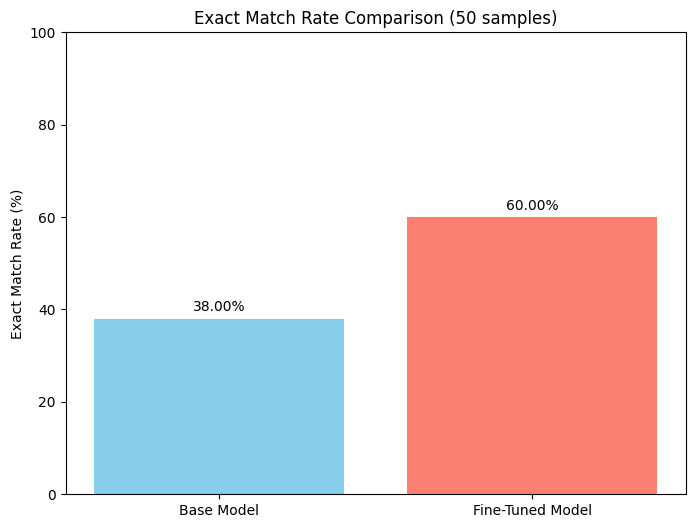

In [12]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
import re
from datasets import load_dataset
from typing import List, Dict
import gc
import matplotlib.pyplot as plt
import numpy as np

def extract_sql_refined(text: str) -> str:
    code_block_match = re.search(r"```(?:sql)?\s*(SELECT\b.*?|INSERT\b.*?|UPDATE\b.*?|DELETE\b.*?|CREATE\b.*?|ALTER\b.*?|DROP\b.*?)\s*```", text, re.DOTALL | re.IGNORECASE)
    if code_block_match:
        sql = code_block_match.group(1).strip()
        if sql.endswith(';'):
            sql = sql[:-1].strip()
        return ' '.join(sql.split())

    example_block_match = re.search(r"###\s*Example:\s*(SELECT\b.*?)(?=\n\n|###\s*\w+:|\Z|View\b|Explanation\b)", text, re.DOTALL | re.IGNORECASE)
    if example_block_match:
        sql = example_block_match.group(1).strip()
        if sql.endswith(';'):
            sql = sql[:-1].strip()
        return ' '.join(sql.split())

    fallback_sql_match_semicolon = re.search(
        r"\b(SELECT\b[^;]+?;|INSERT\b[^;]+?;|UPDATE\b[^;]+?;|DELETE\b[^;]+?;|CREATE\b[^;]+?;|ALTER\b[^;]+?;|DROP\b[^;]+?;)(?!\s*```|\s*###\s*(?:Response|Instruction))",
        text, re.IGNORECASE | re.DOTALL
    )
    if fallback_sql_match_semicolon:
        sql = fallback_sql_match_semicolon.group(1).strip()
        if sql.endswith(';'):
             sql = sql[:-1].strip()
        return ' '.join(sql.split())

    fallback_sql_match_no_semicolon = re.search(
        r"\b(SELECT\b.*?|INSERT\b.*?|UPDATE\b.*?|DELETE\b.*?|CREATE\b.*?|ALTER\b.*?|DROP\b.*?)"
        r"(?=\s*(?:View\b|Explanation\b|Example\b|Note\b|The query\b|This SQL\b|Answer\b|OFFSET\b|LIMIT\b|###\s*(?:Response|Instruction)|```|\Z|SELECT\b|INSERT\b|UPDATE\b|DELETE\b|CREATE\b|ALTER\b|DROP\b))",
        text, re.IGNORECASE | re.DOTALL
    )
    if fallback_sql_match_no_semicolon:
        sql = fallback_sql_match_no_semicolon.group(1).strip()
        if sql.endswith(';'):
            sql = sql[:-1].strip()
        return ' '.join(sql.split())

    lines = text.strip().splitlines()
    if lines:
        first_line = lines[0].strip()
        if re.match(r"^(SELECT|INSERT|UPDATE|DELETE|CREATE|ALTER|DROP)\b", first_line, re.IGNORECASE):
            sql_candidate = first_line
            if sql_candidate.endswith(';'):
                sql_candidate = sql_candidate[:-1].strip()
            return ' '.join(sql_candidate.split())
    return ' '.join(text.strip().split())


def evaluate_model_exact_match(model, tokenizer, samples: List[Dict], model_name: str = "Model", verbose: bool = False) -> Dict:
    exact_matches = 0
    results_log = []

    if verbose:
        print(f"\n--- Starting Exact Match Evaluation for {len(samples)} samples with {model_name} ---")

    for i, ex in enumerate(samples):
        if verbose and (i + 1) % 10 == 0 :
             print(f"--- {model_name} - Processing Sample {i+1}/{len(samples)} ---")

        prompt = f"### Instruction:\nGiven the following database schema and question, write an appropriate SQL query.\n\nSchema:\n{ex['context']}\n\nQuestion:\n{ex['question']}\n\n### Response:\n"
        inputs = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True, max_length=1024).to(model.device)

        with torch.no_grad():
            output = model.generate(
                **inputs,
                max_new_tokens=256,
                pad_token_id=tokenizer.eos_token_id,
                do_sample=False,
            )

        input_ids_length = inputs.input_ids.shape[1]
        generated_ids = output[0][input_ids_length:]
        raw_generation = tokenizer.decode(generated_ids, skip_special_tokens=True).strip()

        if "### Response:" in raw_generation:
             raw_generation = raw_generation.split("### Response:")[-1].strip()
        elif "Response:" in raw_generation:
             raw_generation = raw_generation.split("Response:")[-1].strip()

        generated_sql = extract_sql_refined(raw_generation)
        gold_sql = ex['answer'].strip()

        gold_sql_for_comparison = gold_sql.lower().replace("'", '"')
        generated_sql_for_comparison = generated_sql.lower().replace("'", '"')

        is_exact = generated_sql_for_comparison == gold_sql_for_comparison

        if verbose:
            # print(f"\n[{model_name} RAW MODEL OUTPUT]:\n{raw_generation}\n")
            # print(f"  Gold SQL (raw): '{gold_sql}'")
            # print(f"  Generated SQL (extracted): '{generated_sql}'")
            # print(f"  Gold SQL (normalized): '{gold_sql_for_comparison}'")
            # print(f"  Generated SQL (normalized): '{generated_sql_for_comparison}'")
            # print(f"  Comparison Result (normalized): {is_exact}")
            # if not is_exact:
            #
            #     pass
            pass


        if is_exact:
            exact_matches += 1

        results_log.append({
            'question': ex['question'],
            'gold_sql': gold_sql,
            'generated_sql_extracted': generated_sql,
            'exact_match_after_normalization': is_exact,
        })

    if verbose:
        print(f"\n--- {model_name} - Exact Match Evaluation Complete ---")

    total_samples = len(samples)
    return {
        'exact_match_count': exact_matches,
        'total_samples': total_samples,
        'exact_match_rate': exact_matches / total_samples if total_samples > 0 else 0,
        'results_log': results_log
    }

def main():
    gc.collect()
    torch.cuda.empty_cache()

    verbose_logging = False

    try:
        dataset = load_dataset("b-mc2/sql-create-context", split="train")
        split = dataset.train_test_split(test_size=0.1, seed=1399, shuffle=True)
        val_data = split["test"].shuffle(seed=1399)

        num_samples_to_evaluate = 50
        if len(val_data) < num_samples_to_evaluate:
            print(f"Warning: Requested {num_samples_to_evaluate} samples, but validation set only has {len(val_data)}. Using all available.")
            num_samples_to_evaluate = len(val_data)

        if num_samples_to_evaluate == 0:
            print("Error: No samples available for evaluation.")
            return

        samples_to_evaluate = val_data.select(range(num_samples_to_evaluate))
        print(f"Evaluating on {len(samples_to_evaluate)} samples.")
    except Exception as e:
        print(f"Failed to load or process dataset: {e}")
        return

    finetuned_model_path = "/content/drive/MyDrive/Codes_and_models/Llama3/llama3-sql-lora/final-merged"
    base_model_id = "meta-llama/Meta-Llama-3-8B-Instruct"

    ft_results = None
    base_results = None

    print(f"\n=== Loading Fine-Tuned LLaMA 3 Model: {finetuned_model_path} ===")
    try:
        ft_tokenizer = AutoTokenizer.from_pretrained(finetuned_model_path, trust_remote_code=True)
        ft_tokenizer.pad_token = ft_tokenizer.eos_token
        ft_model = AutoModelForCausalLM.from_pretrained(
            finetuned_model_path,
            device_map="auto",
            torch_dtype=torch.bfloat16
        ).eval()

        print(f"\n=== Evaluating Fine-Tuned Model on {len(samples_to_evaluate)} samples (Exact Match Only) ===")
        ft_results = evaluate_model_exact_match(ft_model, ft_tokenizer, samples_to_evaluate, model_name="Fine-Tuned Model", verbose=verbose_logging)

        print(f"\n--- Fine-Tuned Model Exact Match Summary ---")
        print(f"Exact Matches: {ft_results['exact_match_count']}/{ft_results['total_samples']} "
              f"({ft_results['exact_match_rate']:.2%})")

        del ft_model
        del ft_tokenizer
        gc.collect()
        torch.cuda.empty_cache()
        print("Fine-tuned model resources released.")
    except Exception as e:
        print(f"Error during Fine-Tuned Model evaluation: {e}")

    print(f"\n=== Loading Base LLaMA 3 Model: {base_model_id} ===")
    try:
        base_tokenizer = AutoTokenizer.from_pretrained(base_model_id, trust_remote_code=True)
        base_tokenizer.pad_token = base_tokenizer.eos_token
        base_model = AutoModelForCausalLM.from_pretrained(
            base_model_id,
            device_map="auto",
            torch_dtype=torch.bfloat16
        ).eval()

        print(f"\n=== Evaluating Base Model on {len(samples_to_evaluate)} samples (Exact Match Only) ===")
        base_results = evaluate_model_exact_match(base_model, base_tokenizer, samples_to_evaluate, model_name="Base Model", verbose=verbose_logging)

        print(f"\n--- Base Model Exact Match Summary ---")
        print(f"Exact Matches: {base_results['exact_match_count']}/{base_results['total_samples']} "
              f"({base_results['exact_match_rate']:.2%})")

        del base_model
        del base_tokenizer
        gc.collect()
        torch.cuda.empty_cache()
        print("Base model resources released.")
    except Exception as e:
        print(f"Error during Base Model evaluation: {e}")

    print("\n--- Overall Evaluation Complete ---")

    if ft_results and base_results:
        model_names = ['Base Model', 'Fine-Tuned Model']
        exact_match_rates = [
            base_results['exact_match_rate'] * 100, # Convert to percentage
            ft_results['exact_match_rate'] * 100   # Convert to percentage
        ]

        try:
            plt.figure(figsize=(8, 6))
            bars = plt.bar(model_names, exact_match_rates, color=['skyblue', 'salmon'])
            plt.ylabel('Exact Match Rate (%)')
            plt.title(f'Exact Match Rate Comparison ({len(samples_to_evaluate)} samples)')
            plt.ylim(0, 100) # Y-axis from 0 to 100%

            for bar in bars:
                yval = bar.get_height()
                plt.text(bar.get_x() + bar.get_width()/2.0, yval + 1, f'{yval:.2f}%', ha='center', va='bottom')

            plot_filename = "exact_match_comparison.png"
            plt.savefig(plot_filename)
            print(f"\nComparison plot saved as {plot_filename}")

            plt.show()

        except ImportError:
            print("\nMatplotlib not found. Skipping plot generation.")
            print("To generate plots, please install matplotlib: pip install matplotlib")
        except Exception as e:
            print(f"\nError during plot generation: {e}")
    else:
        print("\nSkipping plot generation as one or both model evaluation results are missing.")


if __name__ == "__main__":
    main()